### Install dependencies

In [1]:
# !pip install baselines
# !git clone https://github.com/lanpa/tensorboardX && cd tensorboardX && python setup.py install
# !pip uninstall protobuf -y
# !pip install -U protobuf
# !pip install scikit-image
# !pip install torchvision

### Load Reacher Environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
num_agents = states.shape[0]
allStates = states
print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Modification of the implementatipon of the PPO agent (by Shangtong Zhang )

#### About the PPO Algorithm

PPO or Proximal Policy Optimization algorithm is an Open AI algorithm released in 2017 that gives improved performance and stability against DDPG and TRPO.

![img](https://sarcturus00.github.io/Tidy-Reinforcement-learning/Pseudo_code/PPO.png)

In [3]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from deep_rl import *

import torch
import numpy as np
from deep_rl.utils import *
import torch.multiprocessing as mp
from collections import deque
from skimage.io import imsave
from deep_rl.network import *
from deep_rl.component import *


class BaseAgent:
    def __init__(self, config):
        self.config = config
        self.logger = get_logger(tag=config.tag, log_level=config.log_level)
        self.task_ind = 0
        self.episode_rewards = []
        self.rewards = None
        self.episodic_return = None
    def close(self):
        close_obj(self.task)

    def save(self, filename):
        torch.save(self.network.state_dict(), '%s.model' % (filename))
        with open('%s.stats' % (filename), 'wb') as f:
            pickle.dump(self.config.state_normalizer.state_dict(), f)

    def load(self, filename):
        state_dict = torch.load('%s.model' % filename, map_location=lambda storage, loc: storage)
        self.network.load_state_dict(state_dict)
        with open('%s.stats' % (filename), 'rb') as f:
            self.config.state_normalizer.load_state_dict(pickle.load(f))

    def eval_step(self, state):
        raise NotImplementedError

    def eval_episode(self):
        env = self.config.eval_env
        state = env.reset()
        while True:
            action = self.eval_step(state)
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            if ret is not None:
                break
        return ret

    def eval_episodes(self):
        episodic_returns = []
        for ep in range(self.config.eval_episodes):
            total_rewards = self.eval_episode()
            episodic_returns.append(np.sum(total_rewards))
        self.episode_rewards = episodic_returns
        self.logger.info('steps %d, episodic_return_test %.2f(%.2f)' % (
            self.total_steps, np.mean(episodic_returns), np.std(episodic_returns) / np.sqrt(len(episodic_returns))
        ))
        self.logger.add_scalar('episodic_return_test', np.mean(episodic_returns), self.total_steps)
        return {
            'episodic_return_test': np.mean(episodic_returns),
        }

    def record_online_return(self, info, offset=0):
        if isinstance(info, dict):
            ret = info['episodic_return']
            self.rewards = info['all_rewards']
            if(self.rewards is not None):
                episode = len(self.rewards)
            if ret is not None:
                self.episodic_return = ret
#                 self.logger.add_scalar('episodic_return_train', ret, self.total_steps + offset)
#                 self.logger.info('Episode %d, steps %d, episodic_return_train %s' % (episode,self.total_steps + offset, ret))
        elif isinstance(info, tuple):
            for i, info_ in enumerate(info):
                self.record_online_return(info_, i)
        else:
            raise NotImplementedError

    def switch_task(self):
        config = self.config
        if not config.tasks:
            return
        segs = np.linspace(0, config.max_steps, len(config.tasks) + 1)
        if self.total_steps > segs[self.task_ind + 1]:
            self.task_ind += 1
            self.task = config.tasks[self.task_ind]
            self.states = self.task.reset()
            self.states = config.state_normalizer(self.states)

    def record_episode(self, dir, env):
        mkdir(dir)
        steps = 0
        state = env.reset()
        while True:
            self.record_obs(env, dir, steps)
            action = self.record_step(state)
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            steps += 1
            if ret is not None:
                break

    def record_step(self, state):
        raise NotImplementedError

    # For DMControl
    def record_obs(self, env, dir, steps):
        env = env.env.envs[0]
        obs = env.render(mode='rgb_array')
        imsave('%s/%04d.png' % (dir, steps), obs)

class PPOAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        self.task = config.task_fn()
        self.network = config.network_fn()
        self.opt = config.optimizer_fn(self.network.parameters())
        self.total_steps = 0
        self.states = self.task.reset()
        self.states = config.state_normalizer(self.states)

    def step(self):
        config = self.config
        storage = Storage(config.rollout_length)
        states = self.states
        for _ in range(config.rollout_length):
            prediction = self.network(states)
            next_states, rewards, terminals, info = self.task.step(to_np(prediction['a']))
            self.record_online_return(info)
            rewards = config.reward_normalizer(rewards)
            next_states = config.state_normalizer(next_states)
            storage.add(prediction)
            storage.add({'r': tensor(rewards).unsqueeze(-1),
                         'm': tensor(1 - terminals).unsqueeze(-1),
                         's': tensor(states)})
            states = next_states
            self.total_steps += config.num_workers

        self.states = states
        prediction = self.network(states)
        storage.add(prediction)
        storage.placeholder()

        advantages = tensor(np.zeros((config.num_workers, 1)))
        returns = prediction['v'].detach()
        for i in reversed(range(config.rollout_length)):
            returns = storage.r[i] + config.discount * storage.m[i] * returns
            if not config.use_gae:
                advantages = returns - storage.v[i].detach()
            else:
                td_error = storage.r[i] + config.discount * storage.m[i] * storage.v[i + 1] - storage.v[i]
                advantages = advantages * config.gae_tau * config.discount * storage.m[i] + td_error
            storage.adv[i] = advantages.detach()
            storage.ret[i] = returns.detach()

        states, actions, log_probs_old, returns, advantages = storage.cat(['s', 'a', 'log_pi_a', 'ret', 'adv'])
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        advantages = (advantages - advantages.mean()) / advantages.std()

        for _ in range(config.optimization_epochs):
            sampler = random_sample(np.arange(states.size(0)), config.mini_batch_size)
            for batch_indices in sampler:
                batch_indices = tensor(batch_indices).long()
                sampled_states = states[batch_indices]
                sampled_actions = actions[batch_indices]
                sampled_log_probs_old = log_probs_old[batch_indices]
                sampled_returns = returns[batch_indices]
                sampled_advantages = advantages[batch_indices]

                prediction = self.network(sampled_states, sampled_actions)
                ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()
                obj = ratio * sampled_advantages
                obj_clipped = ratio.clamp(1.0 - self.config.ppo_ratio_clip,
                                          1.0 + self.config.ppo_ratio_clip) * sampled_advantages
                policy_loss = -torch.min(obj, obj_clipped).mean() - config.entropy_weight * prediction['ent'].mean()

                value_loss = 0.5 * (sampled_returns - prediction['v']).pow(2).mean()

                self.opt.zero_grad()
                (policy_loss + value_loss).backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), config.gradient_clip)
                self.opt.step()


### Define the Task for the environment and run the training

In [4]:
def run_steps_custom(agent):
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    rewards_deque = deque(maxlen=100)
    rewards_all = []
    while True:
        rewards = agent.episodic_return
        if rewards is not None:
            rewards_deque.append(np.mean(rewards))
            rewards_all.append(np.mean(rewards))
        if config.log_interval and not agent.total_steps % config.log_interval and (rewards is not None):
            agent.logger.info('Episode %d,last %d episodes, mean rewards  %.2f,  steps %d, %.2f steps/s' % (len(rewards_all),len(rewards_deque),np.mean(rewards_deque),agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
#         if config.max_steps and agent.total_steps >= config.max_steps:
#             agent.close()
#             return True,rewards_deque,rewards_all
        if (rewards is not None) and np.mean(rewards_deque) > 30:
            agent.save('./data/model-%s.bin' % (agent_name))
            agent.close()
            return True,rewards_deque,rewards_all

        agent.step()
        agent.switch_task()

class ReacherTask():
    def __init__(self):
#         BaseTask.__init__(self)
        self.name = 'Reacher'
        self.env = env
        self.action_dim = brain.vector_action_space_size
        self.state_dim = brain.vector_observation_space_size
        self.info = {"all_rewards":None}
        self.total_rewards = np.zeros(20)
        self.rewards = []
    def reset(self):
        env_info = self.env.reset(train_mode=True)[brain_name]
        return np.array(env_info.vector_observations)

    def step(self, action):
        action = np.clip(action, -1, 1)
        env_info = self.env.step(action)[brain_name]
        next_state = env_info.vector_observations   # next state
        reward = env_info.rewards                   # reward
        done = env_info.local_done

        self.total_rewards += reward

        if np.any(done):
            self.info['episodic_return'] = self.total_rewards
            self.rewards.append(self.total_rewards)
            self.info['all_rewards'] = self.rewards
            self.total_rewards = np.zeros(20)
            next_state = self.reset()
        else:
            self.info['episodic_return'] = None

        return np.array(next_state), np.array(reward), np.array(done), self.info

    def seed(self, random_seed):
        return 10

def ppo_continuous():
    config = Config()
    config.num_workers = num_agents
    task_fn = lambda : ReacherTask()
    config.task_fn = task_fn
    config.eval_env = task_fn()

    config.network_fn = lambda: GaussianActorCriticNet(
        config.state_dim, config.action_dim, actor_body=FCBody(config.state_dim),
        critic_body=FCBody(config.state_dim))
    config.optimizer_fn = lambda params: torch.optim.Adam(params, 3e-4, eps=1e-5)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 2048*4
    config.optimization_epochs = 10
    config.mini_batch_size = 32
    config.ppo_ratio_clip = 0.2
    config.log_interval = 2048*4
    config.max_steps = 1e8
    config.state_normalizer = MeanStdNormalizer()
    return run_steps_custom(PPOAgent(config))

success, rewards_deque, rewards_all = ppo_continuous()

INFO:root:Episode 1,last 1 episodes, mean rewards  0.27,  steps 163840, 105.20 steps/s
INFO:root:Episode 2,last 2 episodes, mean rewards  0.27,  steps 327680, 106.99 steps/s
INFO:root:Episode 3,last 3 episodes, mean rewards  0.30,  steps 491520, 106.19 steps/s
INFO:root:Episode 4,last 4 episodes, mean rewards  0.33,  steps 655360, 104.33 steps/s
INFO:root:Episode 5,last 5 episodes, mean rewards  0.41,  steps 819200, 103.83 steps/s
INFO:root:Episode 6,last 6 episodes, mean rewards  0.49,  steps 983040, 114.76 steps/s
INFO:root:Episode 7,last 7 episodes, mean rewards  0.57,  steps 1146880, 101.62 steps/s
INFO:root:Episode 8,last 8 episodes, mean rewards  0.64,  steps 1310720, 101.48 steps/s
INFO:root:Episode 9,last 9 episodes, mean rewards  0.74,  steps 1474560, 101.28 steps/s
INFO:root:Episode 10,last 10 episodes, mean rewards  0.85,  steps 1638400, 100.69 steps/s
INFO:root:Episode 11,last 11 episodes, mean rewards  0.98,  steps 1802240, 100.00 steps/s
INFO:root:Episode 12,last 12 episo

INFO:root:Episode 92,last 92 episodes, mean rewards  29.10,  steps 15073280, 105.50 steps/s
INFO:root:Episode 93,last 93 episodes, mean rewards  29.20,  steps 15237120, 104.80 steps/s
INFO:root:Episode 94,last 94 episodes, mean rewards  29.31,  steps 15400960, 93.96 steps/s
INFO:root:Episode 95,last 95 episodes, mean rewards  29.39,  steps 15564800, 94.06 steps/s
INFO:root:Episode 96,last 96 episodes, mean rewards  29.49,  steps 15728640, 94.54 steps/s
INFO:root:Episode 97,last 97 episodes, mean rewards  29.58,  steps 15892480, 95.01 steps/s
INFO:root:Episode 98,last 98 episodes, mean rewards  29.67,  steps 16056320, 94.47 steps/s
INFO:root:Episode 99,last 99 episodes, mean rewards  29.75,  steps 16220160, 104.51 steps/s
INFO:root:Episode 100,last 100 episodes, mean rewards  29.84,  steps 16384000, 93.45 steps/s
INFO:root:Episode 101,last 100 episodes, mean rewards  30.22,  steps 16547840, 93.63 steps/s


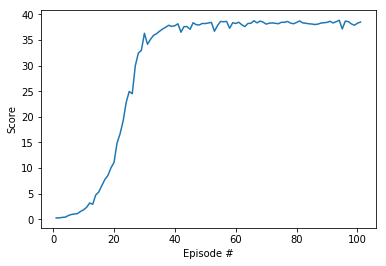

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards_all)+1), rewards_all)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()